<div align="center">
  <h1>Regulatory Motif Enrichment Analysis</h1>
</div>

<p align="center">
  <img src="regulatory_dna.jpg" />
</p>


In this tutorial, we’ll learn how to analyze DNA sequence motifs. Motifs are short DNA patterns that transcription factors bind to, and analyzing them can help us understand gene regulation.

We’ll explore two complementary ways to study motifs:

1. **Motif enrichment in accessible regions** – We'll identify which motifs are found more often in genomic regions (called peaks) that are more accessible in specific groups of cells. This helps us find transcription factors that might be active in those cells.

2. **Differential motif activity analysis** – We’ll also look at how the activity of specific motifs changes between different cell types or conditions. This method uses accessibility patterns to estimate how active certain transcription factors are in different groups of cells.

Together, these approaches give us insight into the regulatory mechanisms controlling gene expression in our dataset.

---

In this tutorial, we will be working with a special type of data called single-cell ATAC-seq, which tells us which parts of the DNA are open and accessible in individual cells. This is important because open DNA regions are often where important regulatory elements, like transcription factors, bind to control gene activity.

### We will in particular be focussing on two tools: <span style="color:red">Signac</span> and <span style="color:red">chrom​var</span>



The dataset we’re using comes from 10x Genomics, a company that provides high-quality biological data. Specifically, the data includes cells from the PBMC, so we’ll be able to study how DNA accessibility varies across different immune cell types.



### You will need to install these extra packages for this session.


- BiocManager::install("JASPAR2020")



- BiocManager::install("TFBSTools")


- BiocManager::install("BSgenome.Hsapiens.UCSC.hg38")

- install.packages("ggseqlogo")
- install.packages('VennDiagram')


### To get started, we’ll first load the necessary packages.

In [3]:
library(Signac)
library(Seurat)
library(JASPAR2020)
library(TFBSTools)
library(BSgenome.Hsapiens.UCSC.hg38)
library(patchwork)
library(GenomicRanges)
library(ggseqlogo)
library(ggplot2)
library(VennDiagram)

### Reading data

- Seurat object processed from the previous session

In [4]:
getwd()

[1] "/lab-share/Neph-Lee-e2/Public/arather/Workshop_cdn/Data"

In [5]:
start_time <- Sys.time()
file <- "PBMC_motif.rds"
PBMC_obj <- readRDS(file)
end_time <- Sys.time()
cat("Loading time:", end_time - start_time, "seconds\n")


Loading time: 34.41975 seconds


In [4]:
PBMC_obj

An object of class Seurat 
419071 features across 17214 samples within 4 assays 
Active assay: ATAC (130381 features, 0 variable features)
 2 layers present: counts, data
 3 other assays present: RNA, SCT, chromvar
 6 dimensional reductions calculated: pca, harmony_rna, umap, atac.integrated_lsi, atac.umap, wnn.umap

In [6]:
Assays(PBMC_obj)

[1] "RNA"      "SCT"      "ATAC"     "chromvar"

In [7]:
Layers(PBMC_obj[["ATAC"]])

[1] "counts" "data"

##### The following R code gives a sneak peek into the raw ATAC-seq count matrix stored in a Seurat object, `rows` correspond to peaks and `cols` to cells

In [8]:
peak_matrix <- GetAssayData(PBMC_obj, assay = "ATAC", layer = "counts")
as.matrix(peak_matrix[5:10, 0:5])  
dim(peak_matrix)


,sample1_AAACAGCCAGAATGAC-1,sample1_AAACAGCCAGCTACGT-1,sample1_AAACAGCCAGGCCTTG-1,sample1_AAACATGCAGCAATAA-1,sample1_AAACATGCAGCCAGAA-1
chr1-267570-268458,0,0,0,0,0
chr1-270881-271760,0,0,0,0,0
chr1-585749-586643,0,0,0,0,0
chr1-629499-630394,1,0,0,0,0
chr1-633578-634475,2,0,1,2,1
chr1-778287-779202,1,0,1,1,0


[1] 130381  17214

In [8]:
#DefaultAssay(PBMC_obj) <- "ATAC"

##### The following code generates a UMAP projection from a Seurat object (PBMC_obj), visualizing clusters of cells in 2D space, The umap shows there are 14 clusters in the data

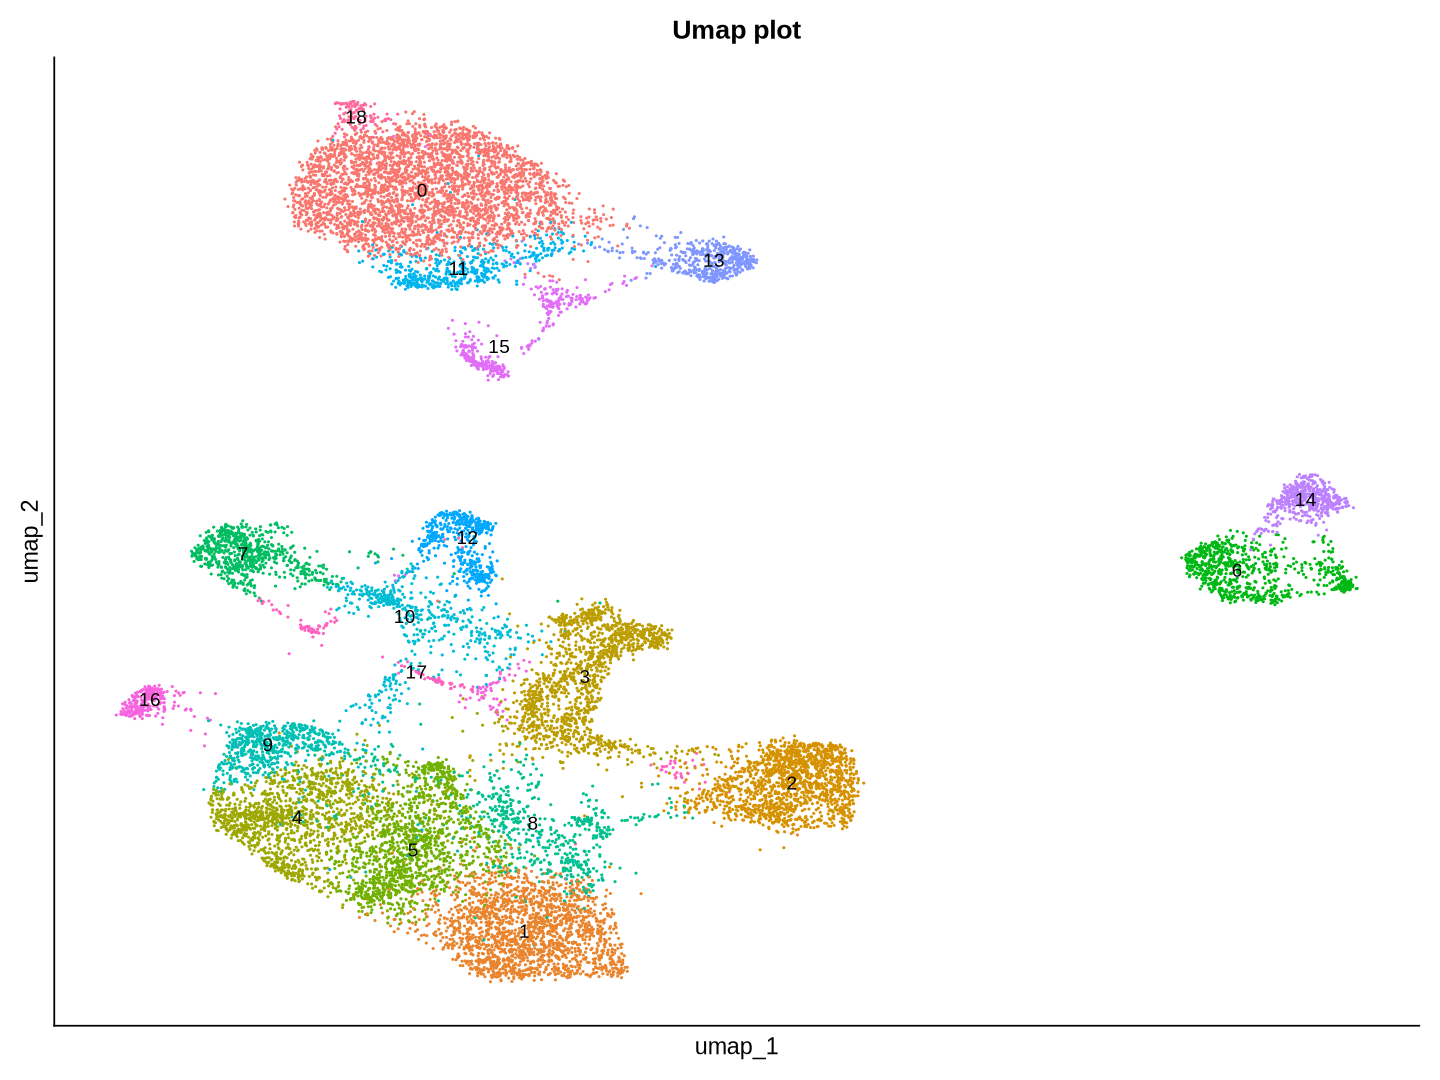

In [9]:
options(repr.plot.width = 12, repr.plot.height = 9)
p1 <- DimPlot(PBMC_obj, reduction = "wnn.umap", label = TRUE, pt.size = 0.1) + 
  NoLegend() +
  labs(x = "umap_1", y = "umap_2", title = "Umap plot") +
  theme(
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    plot.title = element_text(hjust = 0.5)  
  )

p1


In [10]:
colnames(PBMC_obj@meta.data)

[1] "orig.ident"                        "nCount_RNA"                       
 [3] "nFeature_RNA"                      "dataset"                          
 [5] "perc.mt"                           "perc.ribo"                        
 [7] "perc.hb"                           "scDblFinder.cluster"              
 [9] "scDblFinder.class"                 "scDblFinder.score"                
[11] "scDblFinder.weighted"              "scDblFinder.difficulty"           
[13] "scDblFinder.cxds_score"            "scDblFinder.mostLikelyOrigin"     
[15] "scDblFinder.originAmbiguous"       "scDblFinder.p"                    
[17] "barcode"                           "nCount_SCT"                       
[19] "nFeature_SCT"                      "SCT_snn_res.0.8"                  
[21] "seurat_clusters"                   "annot_cell_type"                  
[23] "nCount_ATAC"                       "nFeature_ATAC"                    
[25] "orig.ident.1"                      "nCount_ATAC.1"                    
[27] "nFeature_ATAC.1"                   "gex_barcode"                      
[29] "atac_barcode"                      "is_cell"                          
[31] "excluded_reason"                   "gex_raw_reads"                    
[33] "gex_mapped_reads"                  "gex_conf_intergenic_reads"        
[35] "gex_conf_exonic_reads"             "gex_conf_intronic_reads"          
[37] "gex_conf_exonic_unique_reads"      "gex_conf_exonic_antisense_reads"  
[39] "gex_conf_exonic_dup_reads"         "gex_exonic_umis"                  
[41] "gex_conf_intronic_unique_reads"    "gex_conf_intronic_antisense_reads"
[43] "gex_conf_intronic_dup_reads"       "gex_intronic_umis"                
[45] "gex_conf_txomic_unique_reads"      "gex_umis_count"                   
[47] "gex_genes_count"                   "atac_raw_reads"                   
[49] "atac_unmapped_reads"               "atac_lowmapq"                     
[51] "atac_dup_reads"                    "atac_chimeric_reads"              
[53] "atac_mitochondrial_reads"          "atac_fragments"                   
[55] "atac_TSS_fragments"                "atac_peak_region_fragments"       
[57] "atac_peak_region_cutsites"         "dataset.1"                        
[59] "nucleosome_signal"                 "nucleosome_percentile"            
[61] "TSS.enrichment"                    "TSS.percentile"                   
[63] "blacklist_ratio"                   "barcode.1"                        
[65] "scDblFinder.cluster.1"             "scDblFinder.class.1"              
[67] "scDblFinder.score.1"               "scDblFinder.weighted.1"           
[69] "scDblFinder.difficulty.1"          "scDblFinder.cxds_score.1"         
[71] "scDblFinder.mostLikelyOrigin.1"    "scDblFinder.originAmbiguous.1"    
[73] "scDblFinder.p.1"                   "amulet.nFrags"                    
[75] "amulet.uniqFrags"                  "amulet.nAbove2"                   
[77] "amulet.total.nAbove2"              "amulet.p"                         
[79] "amulet.q"                          "combined.p"                       
[81] "SCT.weight"                        "ATAC.weight"                      
[83] "wsnn_res.0.8"                      "wsnn_res.0.5"                     
[85] "wsnn_res.0.6"                      "wsnn_res.0.7"

In [12]:

grep("annot", colnames(PBMC_obj@meta.data), value = TRUE, ignore.case = TRUE)


[1] "annot_cell_type"

In [15]:
unique(PBMC_obj@meta.data$annot_cell_type)

[1] CD14+ Mono   NK           Naive CD4 T  CD8 T        B           
[6] Memory CD4 T FCGR3A+ Mono DC          
Levels: Naive CD4 T CD14+ Mono Memory CD4 T B CD8 T FCGR3A+ Mono NK DC

##### UMAP plot of Peripheral Blood Mononuclear Cells (PBMCs) from a Seurat object, colored by annotated cell types.

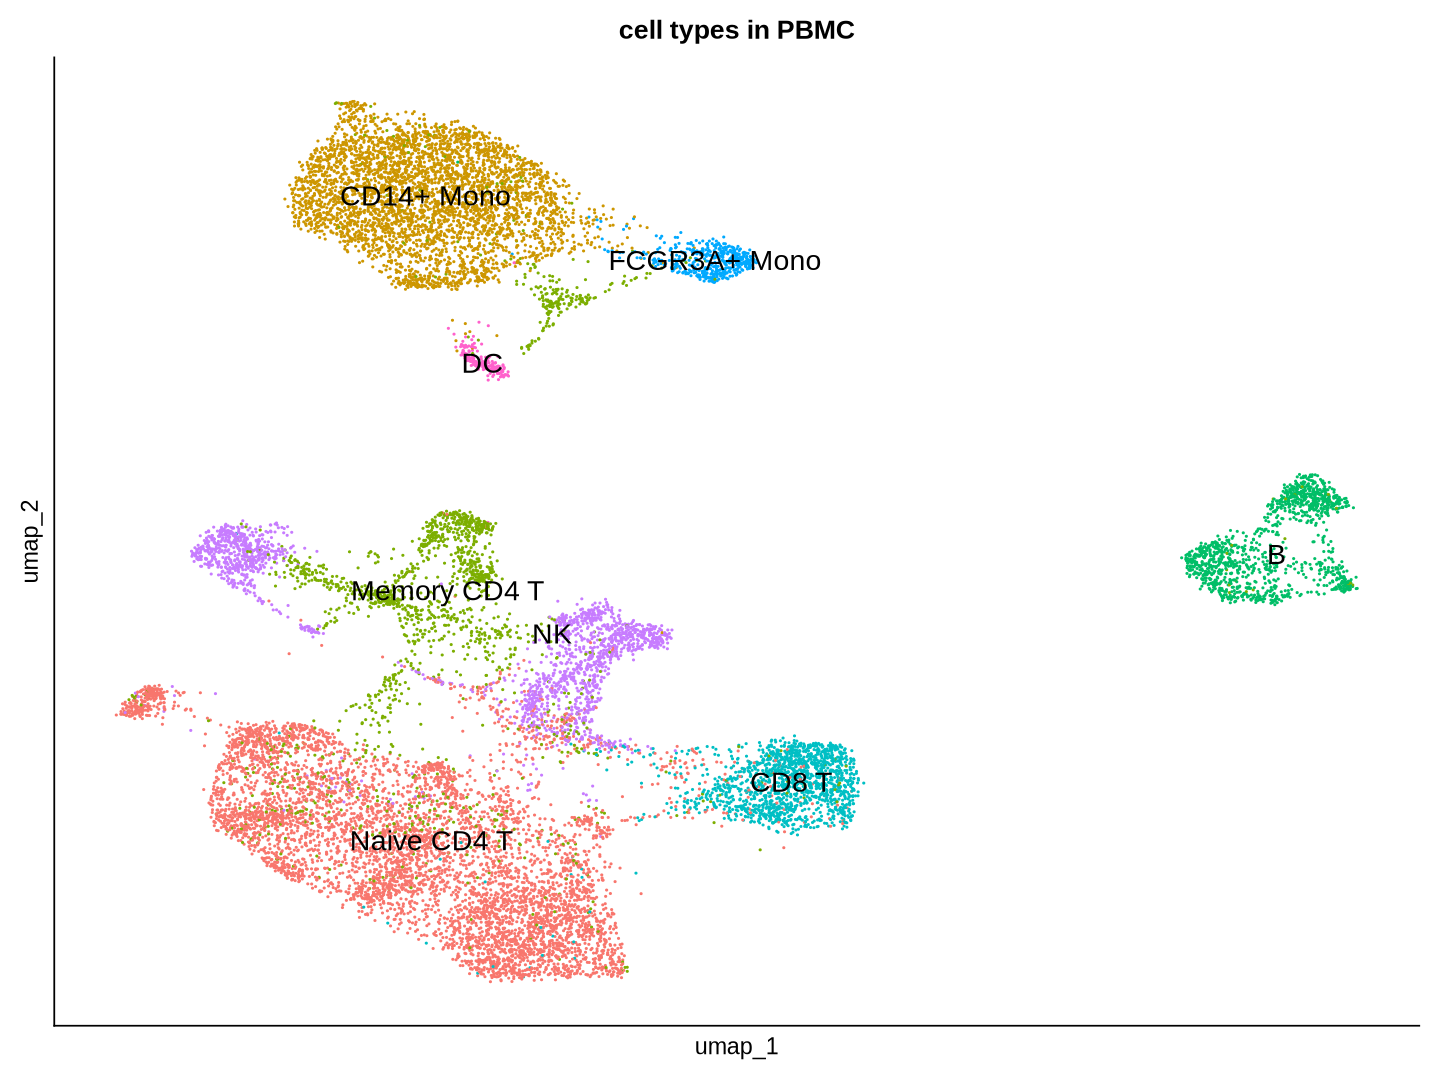

In [16]:
options(repr.plot.width = 12, repr.plot.height = 9)
p1 <- DimPlot(PBMC_obj,  reduction = "wnn.umap", group.by = "annot_cell_type", label = TRUE, label.size = 6)  + 
labs(x = "umap_1", y = "umap_2", title = "cell types in PBMC") + NoLegend() +
  theme(
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    plot.title = element_text(hjust = 0.5)  
  )

p1

## Retrieving DNA Binding Motifs from JASPAR2020

In this step, we are retrieving known DNA binding motifs from the **JASPAR2020** database.

These motifs are represented as **Position Frequency Matrices (PFMs)**, which describe the probability of each nucleotide (A, T, C, G) at each position in a motif.

Motifs are essential for identifying transcription factor binding sites in accessible genomic regions, which can help us understand gene regulation in different cell types.

**The motif collection for individual species is quite limited. We prefer to use core vertebrate collection, which gives 746 motifs. As TF binding motifs are highly conserved across species so we can use JASPAR vertebrate collection for humans**
### What’s inside `pfm`

Each element in `pfm` is a **PFMatrix** object containing:

- **Name and ID** of the motif (e.g., `MA0004.1`)
- The **matrix itself** — a table showing the frequency or probability of each nucleotide (**A**, **T**, **C**, **G**) at each position in the motif
- **Metadata**, such as:
  -  **transcription factor name**
  - **Species**
  - **Data source**
  - **Sequence length**



In [19]:
# Get a list of motif position frequency matrices from the JASPAR database
#opts = list(...)	A list of filtering criteria used to narrow down which motifs to retrieve.
#all_versions = FALSE	Only return the latest version of each motif (avoid duplicates for multiple motif versions).

timing <- system.time({

pfm <- getMatrixSet(
  x = JASPAR2020,
  opts = list(collection = "CORE", tax_group = 'vertebrates', all_versions = FALSE)
)
   
})

cat("Processing time:", timing["elapsed"], "seconds\n")




Processing time: 43.683 seconds


##### Number of pwms in the pfm object

In [20]:
length(pfm@listData)

[1] 746

In [21]:
pfm@listData[1]

$MA0004.1
An object of class PFMatrix
ID: MA0004.1
Name: Arnt
Matrix Class: Basic helix-loop-helix factors (bHLH)
strand: +
Tags: 
$alias
[1] "HIF-1beta,bHLHe2"

$description
[1] "aryl hydrocarbon receptor nuclear translocator"

$family
[1] "PAS domain factors"

$medline
[1] "7592839"

$remap_tf_name
[1] "ARNT"

$symbol
[1] "ARNT"

$tax_group
[1] "vertebrates"

$tfbs_shape_id
[1] "11"

$type
[1] "SELEX"

$unibind
[1] "1"

$collection
[1] "CORE"

$species
         10090 
"Mus musculus" 

$acc
[1] "P53762"

Background: 
   A    C    G    T 
0.25 0.25 0.25 0.25 
Matrix: 
  [,1] [,2] [,3] [,4] [,5] [,6]
A    4   19    0    0    0    0
C   16    0   20    0    0    0
G    0    1    0   20    0   20
T    0    0    0    0   20    0


In [26]:
head(names(pfm),50)

[1] "MA0004.1" "MA0006.1" "MA0019.1" "MA0029.1" "MA0030.1" "MA0031.1"
 [7] "MA0040.1" "MA0041.1" "MA0051.1" "MA0057.1" "MA0059.1" "MA0066.1"
[13] "MA0067.1" "MA0069.1" "MA0070.1" "MA0071.1" "MA0072.1" "MA0073.1"
[19] "MA0074.1" "MA0077.1" "MA0078.1" "MA0084.1" "MA0087.1" "MA0091.1"
[25] "MA0092.1" "MA0101.1" "MA0107.1" "MA0108.2" "MA0109.1" "MA0111.1"
[31] "MA0115.1" "MA0116.1" "MA0119.1" "MA0125.1" "MA0130.1" "MA0135.1"
[37] "MA0139.1" "MA0142.1" "MA0149.1" "MA0138.2" "MA0002.2" "MA0065.2"
[43] "MA0151.1" "MA0152.1" "MA0155.1" "MA0159.1" "MA0160.1" "MA0163.1"
[49] "MA0164.1" "MA0259.1"

In [28]:
pfm[['MA0111.1']]@profileMatrix

A,9,0,2,0,1,8,6,1,10,0,2
C,0,2,0,0,0,0,0,9,0,1,8
G,3,9,10,11,1,0,2,2,2,9,2
T,0,1,0,1,10,4,4,0,0,2,0


#### plotting some motifs

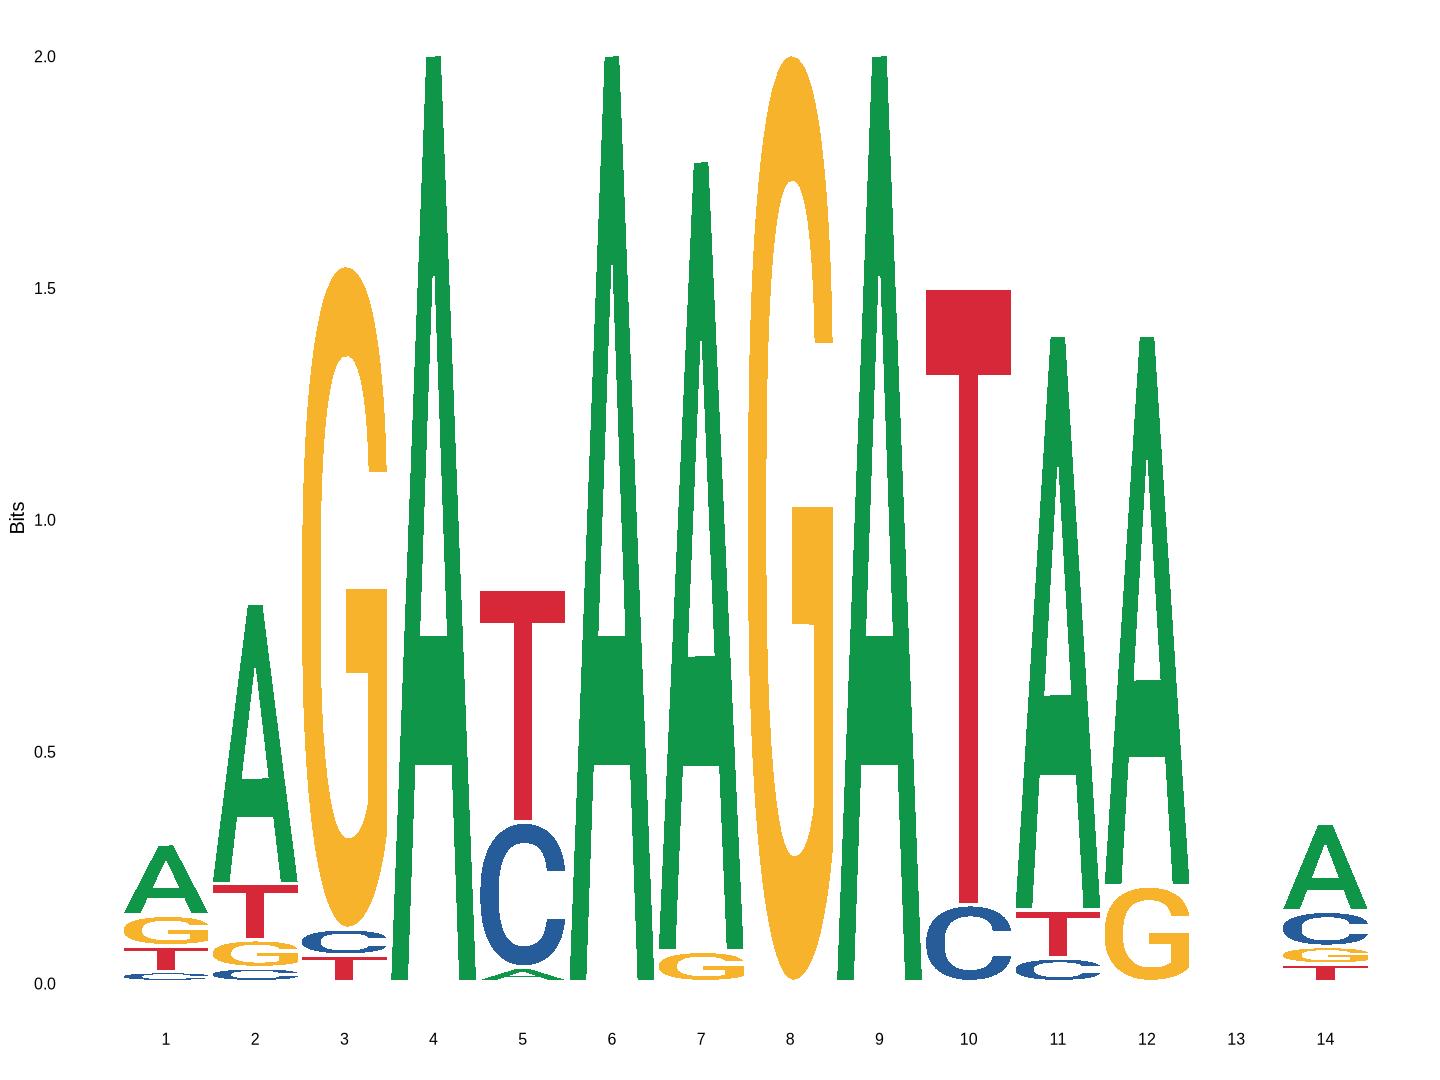

In [29]:
motif_pfm <- pfm[['MA0029.1']]@profileMatrix

suppressWarnings(
    
ggplot() + geom_logo(motif_pfm) + theme_logo()
    
    )

## plot the distribution of motif lenghts 

In [31]:
# Get lengths of each PFM
pfm_lengths <- sapply(pfm, function(m) ncol(m))
summary(pfm_lengths)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   6.00   10.00   12.00   12.04   14.00   24.00 

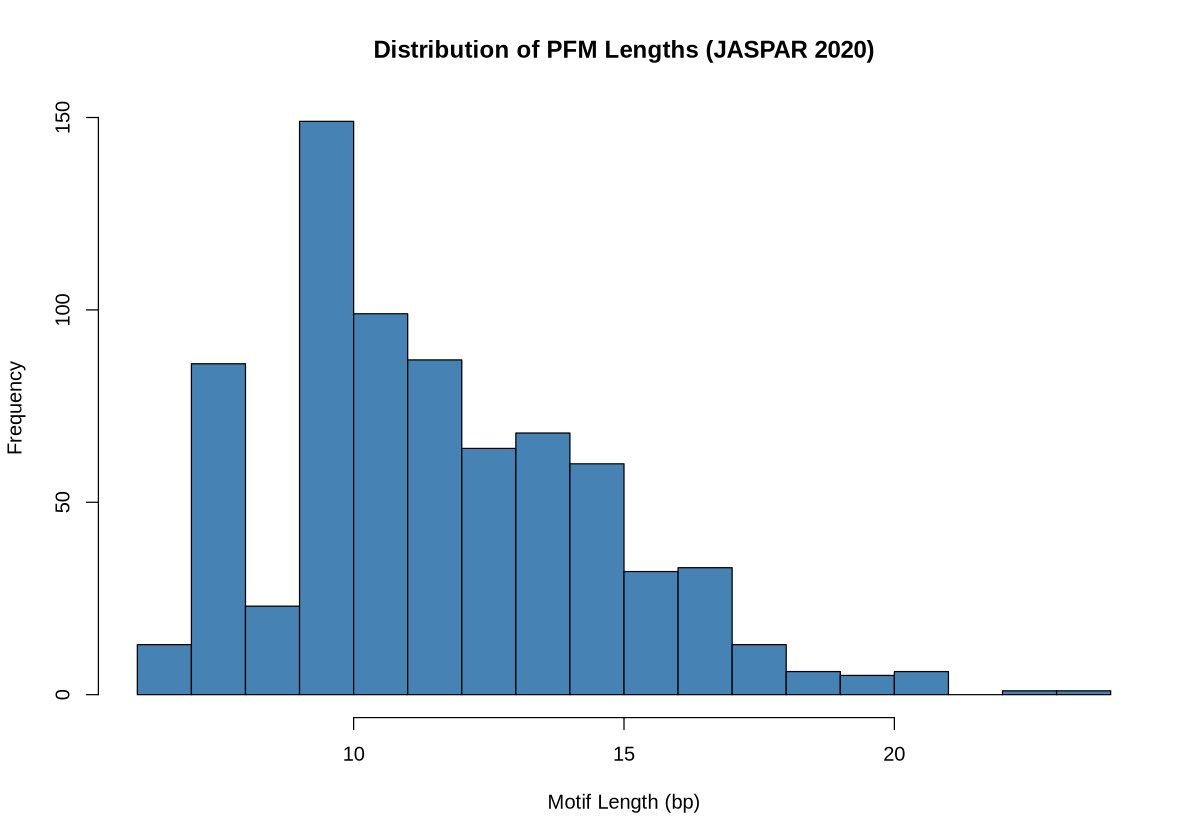

In [32]:
options(repr.plot.width = 10, repr.plot.height = 7)

# Plot histogram of motif lengths
hist(
  pfm_lengths,
  breaks = 20,
  col = "steelblue",
  main = "Distribution of PFM Lengths (JASPAR 2020)",
  xlab = "Motif Length (bp)",
  ylab = "Frequency"
)

### Adding Motif Information to the Seurat Object

The following command adds motif data to the existing Seurat object `PBMC_obj`,. 

`AddMotifs()` scans accessible chromatin regions (ATAC peaks) to annotate which TF binding motifs are present at each peak.

- It uses the human reference genome (`BSgenome.Hsapiens.UCSC.hg38`) to find where specific DNA sequence patterns, known as **motifs**, appear in the accessible chromatin regions.
- The `pfm` (position frequency matrix) contains the DNA patterns of transcription factors that the function will look for.
- This helps connect regions of open chromatin with potential transcription factors that regulate gene activity in `PBMC cells`.



In [22]:
# add motif information to the seurat object. This information is already added to the seurat object. you can safely skip this step 
# timing <- system.time({
    
#   PBMC_obj <- suppressWarnings(
#   AddMotifs(
#       object = PBMC_obj,
#       genome = BSgenome.Hsapiens.UCSC.hg38,
#       pfm = pfm
#     )
      
#   )
# })

# cat("Processing time:", timing["elapsed"], "seconds\n")




In [33]:
PBMC_obj

An object of class Seurat 
419071 features across 17214 samples within 4 assays 
Active assay: ATAC (130381 features, 0 variable features)
 2 layers present: counts, data
 3 other assays present: RNA, SCT, chromvar
 6 dimensional reductions calculated: pca, harmony_rna, umap, atac.integrated_lsi, atac.umap, wnn.umap

In [34]:
PBMC_obj[["ATAC"]]@motifs
motifs <-GetAssayData(PBMC_obj, assay = "ATAC", layer = "motifs")

A Motif object containing 746 motifs in 130381 regions

In [35]:
slotNames(motifs)

[1] "data"        "pwm"         "motif.names" "positions"   "meta.data"

In [36]:
#fetch a matrix specific to a motif `X`
motifs@pwm[['MA0029.1']]

A,14,20,0,27,1,27,26,0,27,0,24,23,6,15
C,2,1,1,0,10,0,0,0,0,3,1,0,7,6
G,6,2,25,0,0,0,1,27,0,0,0,4,7,3
T,5,4,1,0,16,0,0,0,0,24,2,0,7,3


### Identify genomic regions where this motif occurs within open chromatin

In [37]:
head(data.frame((motifs@positions[['MA0029.1']])))

,seqnames,start,end,width,strand,score
,<fct>,<int>,<int>,<int>,<fct>,<dbl>
1,chr1,271390,271403,14,-,11.50336
2,chr1,271395,271408,14,-,11.50336
3,chr1,630110,630123,14,-,11.33392
4,chr1,869513,869526,14,-,12.04368
5,chr1,984585,984598,14,-,11.34202
6,chr1,996143,996156,14,+,14.14835


## Identify genomic regions where this motif occurs within open chromatin specific to a particular chromosome

In [38]:
chr_matches <- subset(motifs@positions[["MA0029.1"]], seqnames == "chr10")
head(data.frame(chr_matches), 10)

,seqnames,start,end,width,strand,score
,<fct>,<int>,<int>,<int>,<fct>,<dbl>
1,chr10,437666,437679,14,-,12.76756
2,chr10,451365,451378,14,-,12.34927
3,chr10,456871,456884,14,-,11.72958
4,chr10,876392,876405,14,+,11.34202
5,chr10,964879,964892,14,+,15.23963
6,chr10,1010453,1010466,14,+,12.99514
7,chr10,1064459,1064472,14,+,11.52495
8,chr10,1134213,1134226,14,-,11.33624
9,chr10,1245435,1245448,14,-,12.09824


### Extract DNA sequences from genomic regions where the specified `motif` is found


In [39]:
df <- data.frame(motifs@positions[["MA0029.1"]])
gr <- GRanges(seqnames = df$seqnames,
              ranges = IRanges(start = df$start, end = df$end),
              strand = df$strand)

# Get DNA sequences
seqs <- suppressWarnings(getSeq(BSgenome.Hsapiens.UCSC.hg38, gr))


# Add sequences to the original data frame
df$sequence <- as.character(seqs)

# View the first few rows
head(df)

,seqnames,start,end,width,strand,score,sequence
,<fct>,<int>,<int>,<int>,<fct>,<dbl>,<chr>
1,chr1,271390,271403,14,-,11.50336,AAGAAAAGAAAAGA
2,chr1,271395,271408,14,-,11.50336,AAGAAAAGAAAAGA
3,chr1,630110,630123,14,-,11.33392,TGGATAAGATTGAA
4,chr1,869513,869526,14,-,12.04368,TAGAAAAGATAGAT
5,chr1,984585,984598,14,-,11.34202,AAGAAAAGAAAAAA
6,chr1,996143,996156,14,+,14.14835,AAGCCAAGATAAAA


### Plotting Motif Distribution Across Chromosomes

In this analysis, we focus on the motif **`some motif`** and examine its distribution across standard human chromosomes.

1. **Define motif and chromosomes:**  
   - We specify the motif of interest.  
   - We limit the analysis to standard chromosomes (`chr1` to `chr22`, plus `chrX` and `chrY`).

2. **Extract motif positions:**  
   Using the `motifs` object, we extract all genomic positions where the motif occurs.

3. **Filter to standard chromosomes:**  
   We clean the data by retaining only motif matches located on standard chromosomes to avoid unplaced or alternative contigs.

4. **Count motif occurrences per chromosome:**  
   We create a frequency table counting how many times the motif appears on each chromosome.

5. **Order counts:**  
   The counts are reordered to follow the natural chromosome order (`chr1` through `chr22`, then `chrX` and `chrY`).

7. **Plot:**  
   Finally, a barplot displays the number of motif matches on each chromosome,
This visualization helps reveal if the motif shows any chromosome-specific enrichment or depletion.


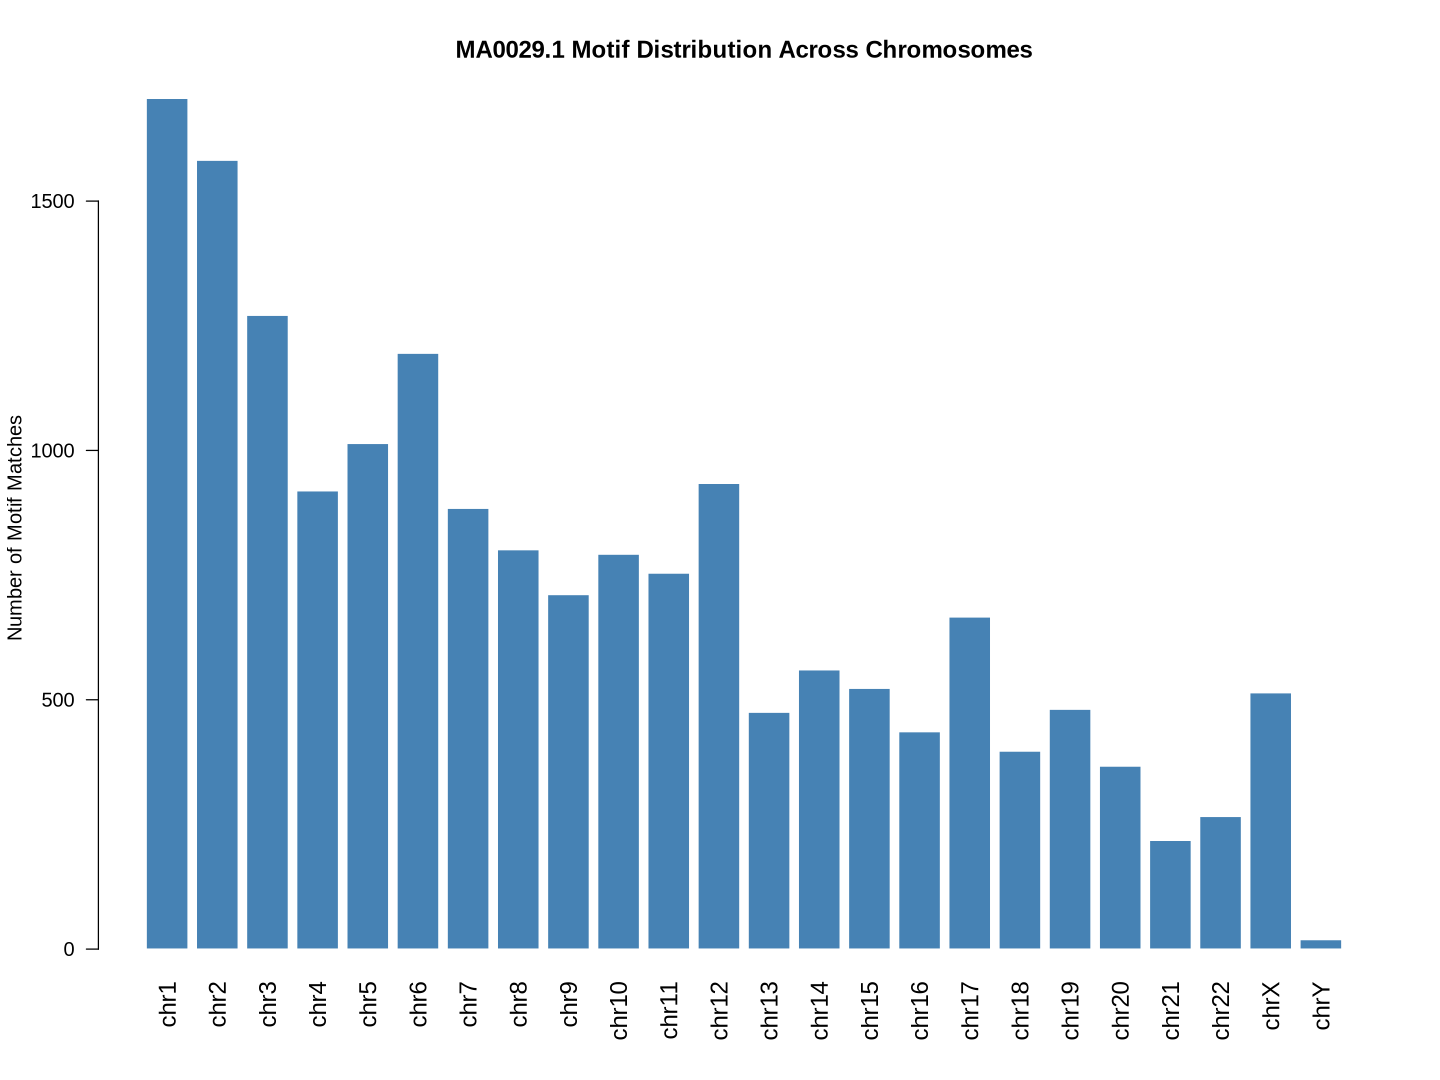

In [40]:
options(repr.plot.width = 12, repr.plot.height = 9)
motif <- "MA0029.1"
standard_chromosomes <- c(paste0("chr", 1:22), "chrX", "chrY")


motif_positions <- motifs@positions[[motif]]


motif_positions_clean <- motif_positions[seqnames(motif_positions) %in% standard_chromosomes]

# Create counts from the cleaned data
motif_chr_counts_clean <- table(seqnames(motif_positions_clean))

chromosome_order <- c(paste0("chr", 1:22), "chrX", "chrY")
motif_chr_counts_ordered <- motif_chr_counts_clean[chromosome_order]


barplot(motif_chr_counts_ordered, 
        main = paste(motif, "Motif Distribution Across Chromosomes"),
        col = "steelblue", 
        las = 2,  
        cex.names = 1.2,  
        ylab = "Number of Motif Matches",
        border = "white")  

### Finding overrepresented motifs

To find important DNA regions that might control specific cell types, we look for DNA patterns (motifs) that appear more often in regions (peaks) that are different between cell types.

In this example, we compare these regions between two types of PBMC cells. Because the data from single-cell ATAC-seq is often sparse (has many zeros), we lower a threshold in the analysis to catch more meaningful differences.

Finally, we use a statistical test called the hypergeometric test to see if the motifs we find are more common than we would expect by chance, comparing to a background set of regions with similar DNA composition.


In [41]:
DefaultAssay(PBMC_obj) <-"ATAC"
Idents(PBMC_obj) <- PBMC_obj$annot_cell_type
table(Idents(PBMC_obj))


 Naive CD4 T   CD14+ Mono Memory CD4 T            B        CD8 T FCGR3A+ Mono 
        6085         3997         1860         1240         1511          466 
          NK           DC 
        1866          189 

## Differential Motif Activity with FindMarkers()
This function identifies differentially active features (e.g., motifs or peaks) between two cell groups — in this case, CD8 T cells vs B cells — within the PBMC_obj Seurat object. The likelihood ratio test (test.use = "LR") is used to account for variability, and nCount_ATAC is included as a latent variable to control for differences in sequencing depth. Only features with increased activity in CD8 T cells (only.pos = TRUE) and present in at least 5% of cells (min.pct = 0.05) are returned.


`avg_log2FC: A positive value means the peak is more accessible in CD8 T cells. For example, 6.6 means ~100x more accessible (2^6.6 ≈ 100).`

`pct.1 Percentage of CD8 T cells where this peak is accessible. For example, 0.585 means 58.5% of CD8 T cells had this peak.`

`Percentage of B cells where this peak is accessible. For example, 0.008 means 0.8% of B cells had this peak accessible.`
`pct.2 Percentage of B cells where this peak is accessible. For example, 0.008 means 0.8% of B cells had this peak accessible.` 

In [42]:
timing <- system.time({

        da_peaks <- suppressWarnings(FindMarkers(
        object = PBMC_obj,
        ident.1 = 'CD8 T',
        ident.2 = 'B', #null, (to compare with rest of the cell types)
        only.pos = TRUE,# Return only positive markers (peaks more accessible in CD8 T than B).
        test.use = 'LR', #wilcox (as a frist step to run faster)
        min.pct = 0.05,#Only test peaks present in at least 5% of cells in either group.
        latent.vars = 'nCount_ATAC'
        )
        )
    
})

cat("Processing time:", timing["elapsed"], "seconds\n")

# get top differentially accessible peaks
top.da.peak <- rownames(da_peaks[da_peaks$p_val < 0.005 & da_peaks$pct.1 > 0.2, ]) # pct.1 > 0.2: Peaks accessible in more than 20% of CD8 T cells.



Processing time: 410.287 seconds


In [43]:
head(da_peaks)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr17-82126428-82127361,6.623277e-305,6.604618,0.585,0.008,8.635495e-300
chr7-138752283-138753207,1.807192e-238,5.331282,0.517,0.016,2.356235e-233
chr10-8332027-8332938,6.704036e-210,5.002208,0.478,0.016,8.740789e-205
chr6-137823790-137824724,2.007368e-206,4.554527,0.482,0.024,2.617226e-201
chr11-3014071-3014987,4.590223e-204,5.807724,0.442,0.009,5.984779e-199
chr17-75036394-75037313,1.066383e-202,5.070659,0.463,0.015,1.390361e-197


In [41]:
head(top.da.peak)

[1] "chr17-82126428-82127361"  "chr7-138752283-138753207"
[3] "chr19-3275610-3276550"    "chr2-109031495-109032448"
[5] "chr10-8332027-8332938"    "chr6-137823790-137824724"

### `FindMotifs()` function to identify transcription factor motifs that are statistically enriched in a set of differentially accessible peaks (`top.da.peak`).

The `FindMotifs()` function in Signac uses a hypergeometric test for enrichment of motifs in a set of peaks, with background peaks matched for GC content.

- scan the differential peaks for for known TFBS
- compare motif frequency agianst a background set of peaks, matched for GC content
- calculate enrichment p-values to identify motifs that appear more often than expected by chance


In [44]:
# test enrichment
enriched.motifs <- FindMotifs(
  object = PBMC_obj,
  features = top.da.peak
)

Selecting background regions to match input sequence characteristics

Matching GC.percent distribution

Testing motif enrichment in 4653 regions



In [45]:
#observed: Number of input peaks (your top.da.peak) that contain this motif.

#background	Number of background peaks (e.g., from the whole dataset) that contain this motif.

#percent.observed	Percent of your input peaks with the motif: (observed / total input peaks) × 100

#percent.background	Percent of background peaks with the motif: (background / total background peaks) × 100.

#fold.enrichment	How much more frequent the motif is in your input peaks than background: percent.observed / percent.background.

head(enriched.motifs)
dim(enriched.motifs)

,motif,observed,background,percent.observed,percent.background,fold.enrichment,pvalue,motif.name,p.adjust
,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
MA0506.1,MA0506.1,1987,5235,42.70363,13.0875,3.262933,0,NRF1,0
MA0632.2,MA0632.2,1225,3280,26.32710,8.2000,3.210622,0,TCFL5,0
MA1122.1,MA1122.1,1448,4632,31.11971,11.5800,2.687367,0,TFDP1,0
MA1650.1,MA1650.1,1966,6297,42.25231,15.7425,2.683964,0,ZBTB14,0
MA1513.1,MA1513.1,3140,11136,67.48334,27.8400,2.423971,0,KLF15,0
MA0732.1,MA0732.1,1964,7170,42.20933,17.9250,2.354774,0,EGR3,0


[1] 746   9

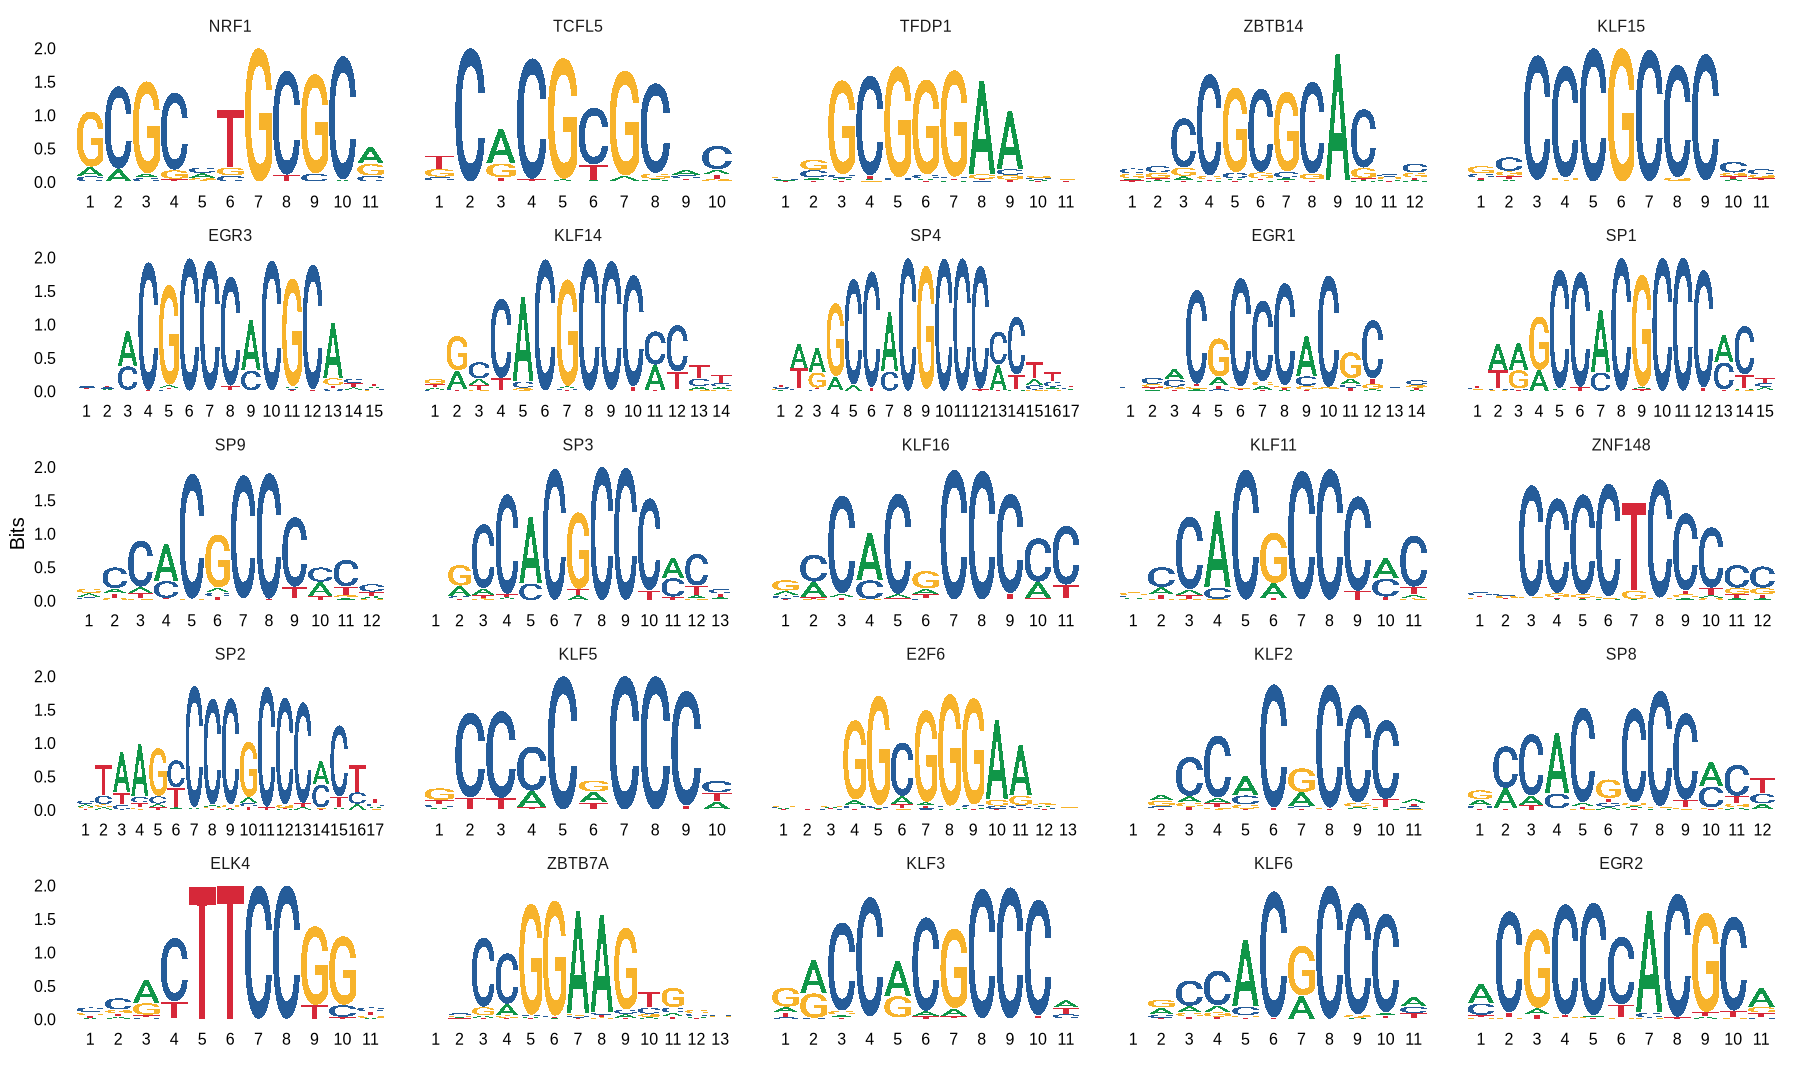

In [48]:
options(repr.plot.width = 15, repr.plot.height = 9)
MotifPlot(
  object = PBMC_obj,
  motifs = head(rownames(enriched.motifs), 25)
)

## Calculating Motif Activities

We can use a tool called **chromVAR** (chromVAR stands for chromatin Variability Across Regions) to measure **how active certain DNA motifs are in each individual cell**. This helps us:

- **Visualize** which motifs are active in which cells
- **Compare** motif activity between different cell types

chromVAR works by finding motifs that are linked to **differences in DNA accessibility** between cells. If a motif shows up more in open (accessible) regions in some cells but not others, chromVAR highlights that.

ChromVAR calculates accessibility deviation across multiple conditions for each motif using a `Z-score` (deviation scores where rows represent different transcription factor motifs and columns represent individual cells. a higher score suggests greater motif activity in that cell.) and is adjusted for known technical bias (GC bias, average accessibility and fraction of reads in peaks). It is specifically designed for scATAC-seq data with a large number of cells.

ChromVAR analysis is revealing how transcription factor regulatory networks differ across immune cell populations, providing insights into the regulatory mechanisms controlling cell identity and function in your PBMC sample.

**MA0497.1 (MEF2C)** Activity (Right plot):

**MEF2C** transcription factor activity varies significantly across cell types
Higher activity (purple/blue regions) appears concentrated in specific cell populations
The monocyte populations (bottom clusters) show particularly high MEF2C activity
T cell populations show more variable MEF2C activity levels




In [38]:
#run this only if you have huge memory and patience
#This code (currently commented out) runs chromVAR, a method used to 
#compute motif activity scores across single cells based on chromatin accessibility data


# PBMC_obj <- suppressWarnings(
#   RunChromVAR(
#     object = PBMC_obj,
#     genome = BSgenome.Hsapiens.UCSC.hg38 #  reference human genome so chromVAR knows the genomic coordinates for motifs
#   )
# )



In [49]:
# Get the chromVAR z-score matrix (default is 'data' slot)

chromvar_matrix <- GetAssayData(PBMC_obj[["chromvar"]], layer = "data")


dim(chromvar_matrix)  # should be 746 x 17214

# View the first 10 motifs across the first 6 cells
chromvar_matrix[1:10, 1:6]


[1]   746 17214

,sample1_AAACAGCCAGAATGAC-1,sample1_AAACAGCCAGCTACGT-1,sample1_AAACAGCCAGGCCTTG-1,sample1_AAACATGCAGCAATAA-1,sample1_AAACATGCAGCCAGAA-1,sample1_AAACATGCAGGCGATA-1
MA0004.1,0.1432530,-0.55312197,-0.6013877,-1.0265227,0.287540584,-0.75852993
MA0006.1,-1.9759939,-0.27259857,-0.8496089,-0.5642570,-0.367567376,0.23501760
MA0019.1,1.5119021,0.73595834,0.2119652,-4.1898597,-1.391480523,0.16355865
MA0029.1,-0.5747241,-1.19631698,-1.7331043,0.8293456,0.405879081,-0.05301740
MA0030.1,1.5520057,-0.17553768,0.5136774,0.5275715,-0.004858498,0.72043441
MA0031.1,-0.9586294,-1.46787410,-1.7772799,0.5269098,0.475945454,-0.36638834
MA0040.1,-0.5481493,-1.42761119,0.6181045,-1.4953357,-1.549022848,0.54473348
MA0041.1,0.4546438,-1.10984218,-0.7675862,-0.5855072,-1.336709958,-0.73346869
MA0051.1,1.0366885,3.42060592,0.9464016,-0.3631131,0.727878336,0.03767686
MA0057.1,1.3714722,0.07183678,-0.1987819,-3.1147100,1.056872127,0.30527062


Warning message:
“The `slot` argument of `FetchData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”


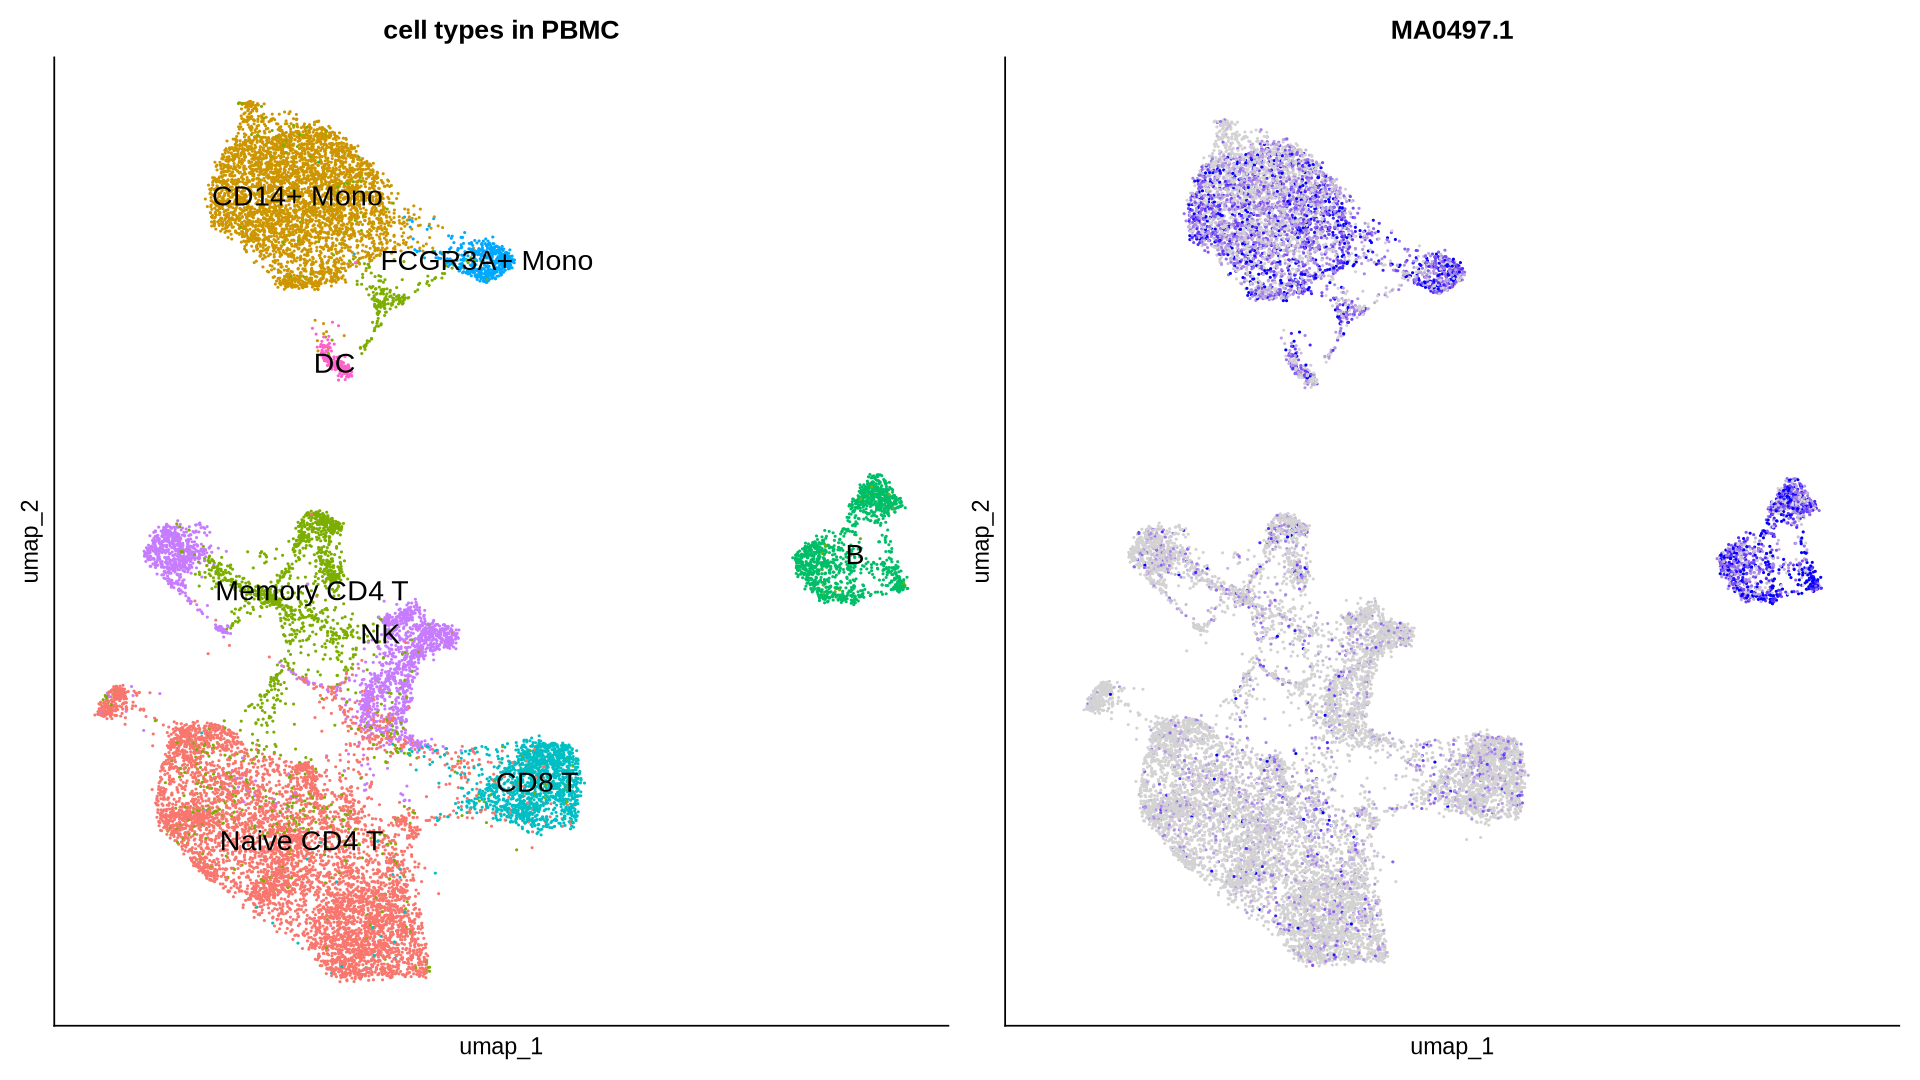

In [50]:
options(repr.plot.width = 16, repr.plot.height = 9)
DefaultAssay(PBMC_obj) <- 'chromvar'

# look at the activity of Mef2c
p2 <- FeaturePlot(
  object = PBMC_obj,
  reduction = "wnn.umap",
  features = "MA0497.1",
  min.cutoff = 'q10',
  max.cutoff = 'q90',
  pt.size = 0.1
) +  
labs(x = "umap_1", y = "umap_2") + NoLegend() +
theme(
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    plot.title = element_text(hjust = 0.5)  
  )
p1 + p2

##  Comparing Motif Activity Between Cell Types

We can also **compare motif activity levels directly between different cell types**. This usually gives similar results to checking which motifs are enriched in peaks that are more accessible in one cell type versus another (as described earlier).

When using the **chromVAR z-scores** to do this comparison, we can adjust the `FindMarkers()` function as follows:

- Set `mean.fxn = rowMeans` to use the **average value** across cells
- Set `fc.name = "avg_diff"` to label the fold-change as the **average difference in z-score** between the two groups

This helps us see **how much more or less active** a motif is in one cell type compared to another.

In [51]:
DefaultAssay(PBMC_obj) <- 'ATAC'

levels(Idents(PBMC_obj))

[1] "Naive CD4 T"  "CD14+ Mono"   "Memory CD4 T" "B"            "CD8 T"       
[6] "FCGR3A+ Mono" "NK"           "DC"

In [52]:
Idents(PBMC_obj) <- PBMC_obj$annot_cell_type
table(Idents(PBMC_obj))


 Naive CD4 T   CD14+ Mono Memory CD4 T            B        CD8 T FCGR3A+ Mono 
        6085         3997         1860         1240         1511          466 
          NK           DC 
        1866          189 

In [53]:
DefaultAssay(PBMC_obj) <- 'chromvar'

In [54]:
differential.activity <- suppressWarnings(
  FindMarkers(
    object = PBMC_obj,
    ident.1 = 'CD8 T',
    ident.2 = 'B',
    only.pos = TRUE,
    mean.fxn = rowMeans,
    fc.name = "avg_diff"
  )
)



In [45]:
head(differential.activity)

,p_val,avg_diff,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MA0768.1,0.000000e+00,2.922843,0.968,0.189,0.000000e+00
MA0523.1,0.000000e+00,3.124312,0.980,0.205,0.000000e+00
MA0769.2,0.000000e+00,2.668352,0.954,0.244,0.000000e+00
MA0002.2,0.000000e+00,2.131982,0.766,0.097,0.000000e+00
MA1421.1,2.202594e-284,1.808044,0.866,0.242,1.643135e-281
MA0511.2,1.518975e-236,1.637089,0.752,0.190,1.133155e-233


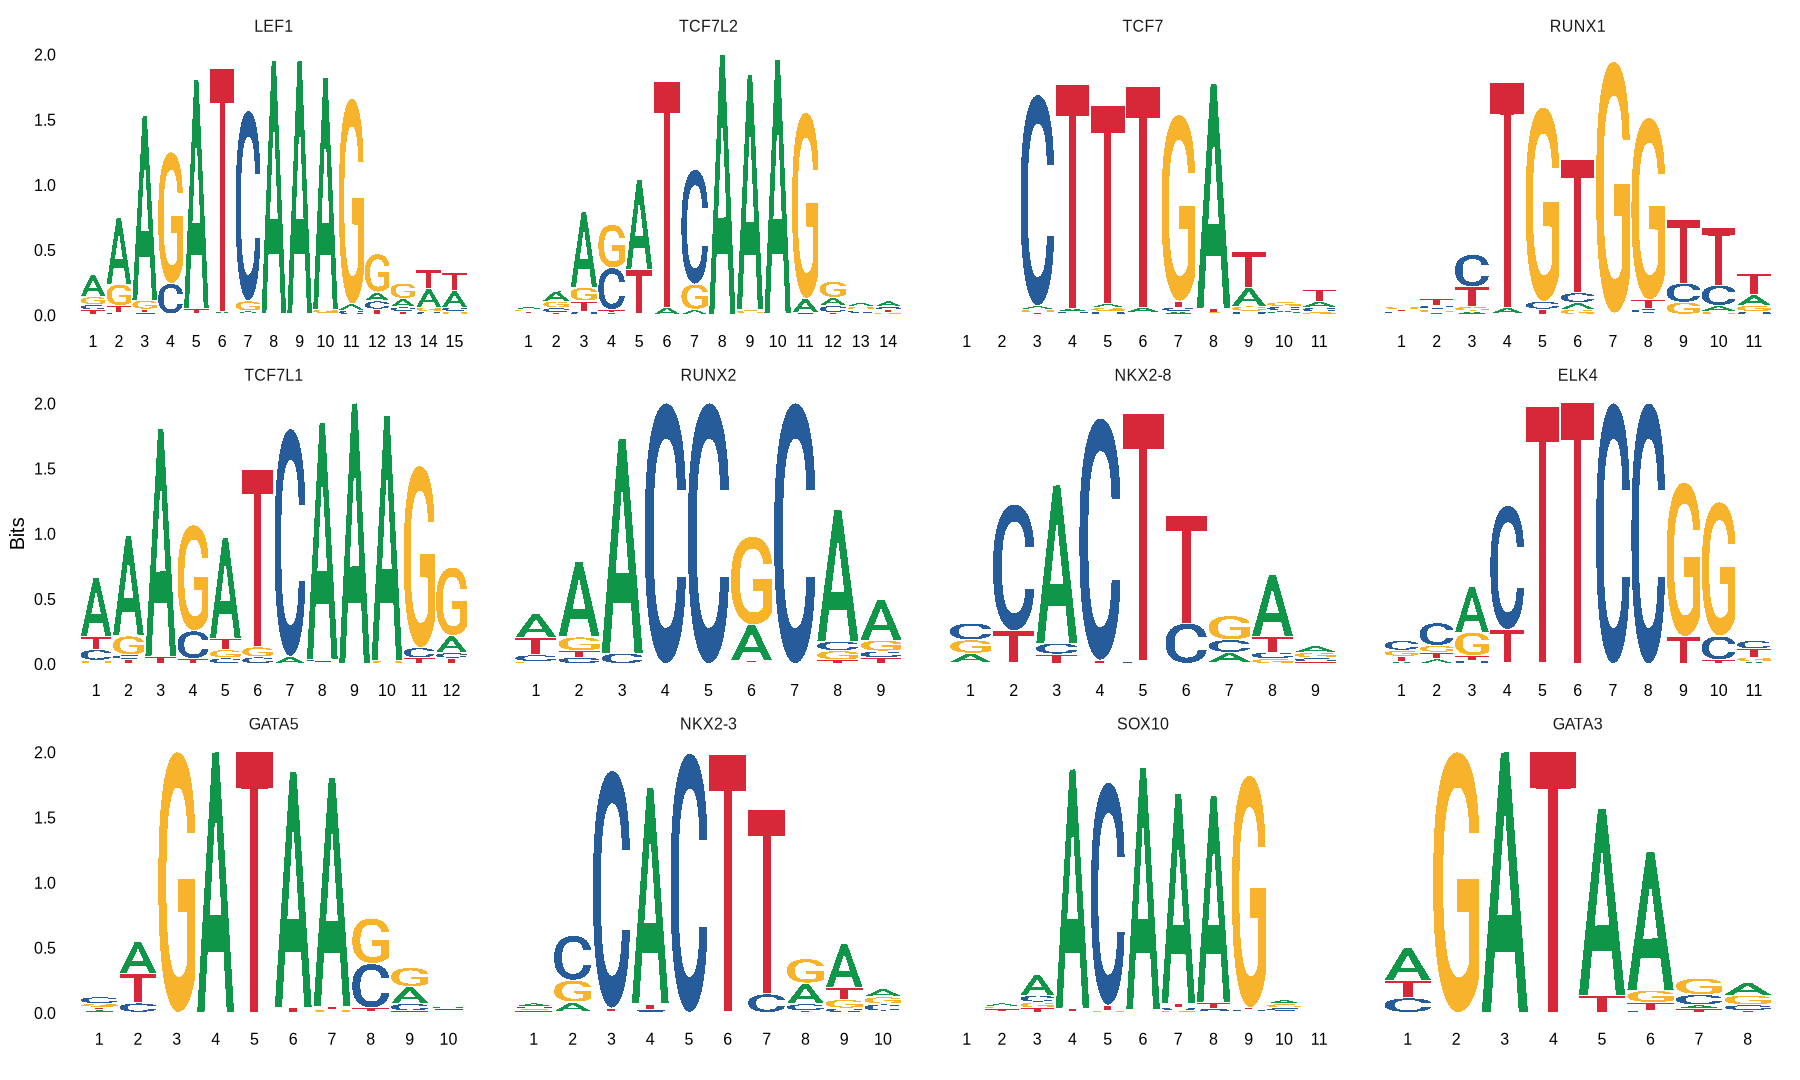

In [55]:
options(repr.plot.width = 15, repr.plot.height = 9)

# Plot first few (you can increase or adjust)
MotifPlot(
  object = PBMC_obj,
  motifs = head(rownames(differential.activity),12),
  assay = 'ATAC'
)

# intersection and complement between `Signac` and `Chromvar`

In [56]:

motifs.diff <- rownames(differential.activity[differential.activity$p_val_adj < 0.05, ])
motifs.enrich <- enriched.motifs$motif[enriched.motifs$p.adjust < 0.05]

# Common motifs
common.motifs <- intersect(motifs.diff, motifs.enrich)

# Motifs only in differential.activity
only.diff <- setdiff(motifs.diff, motifs.enrich)

# Motifs only in enriched.motifs
only.enrich <- setdiff(motifs.enrich, motifs.diff)


cat("Common motifs:", length(common.motifs), "\n")
cat("Only in chromvar:", length(only.diff), "\n")
cat("Only in enriched.motifs:", length(only.enrich), "\n")


#View(common.motifs)
#View(only.diff)
#View(only.enrich)


Common motifs: 60 
Only in chromvar: 128 
Only in enriched.motifs: 117 


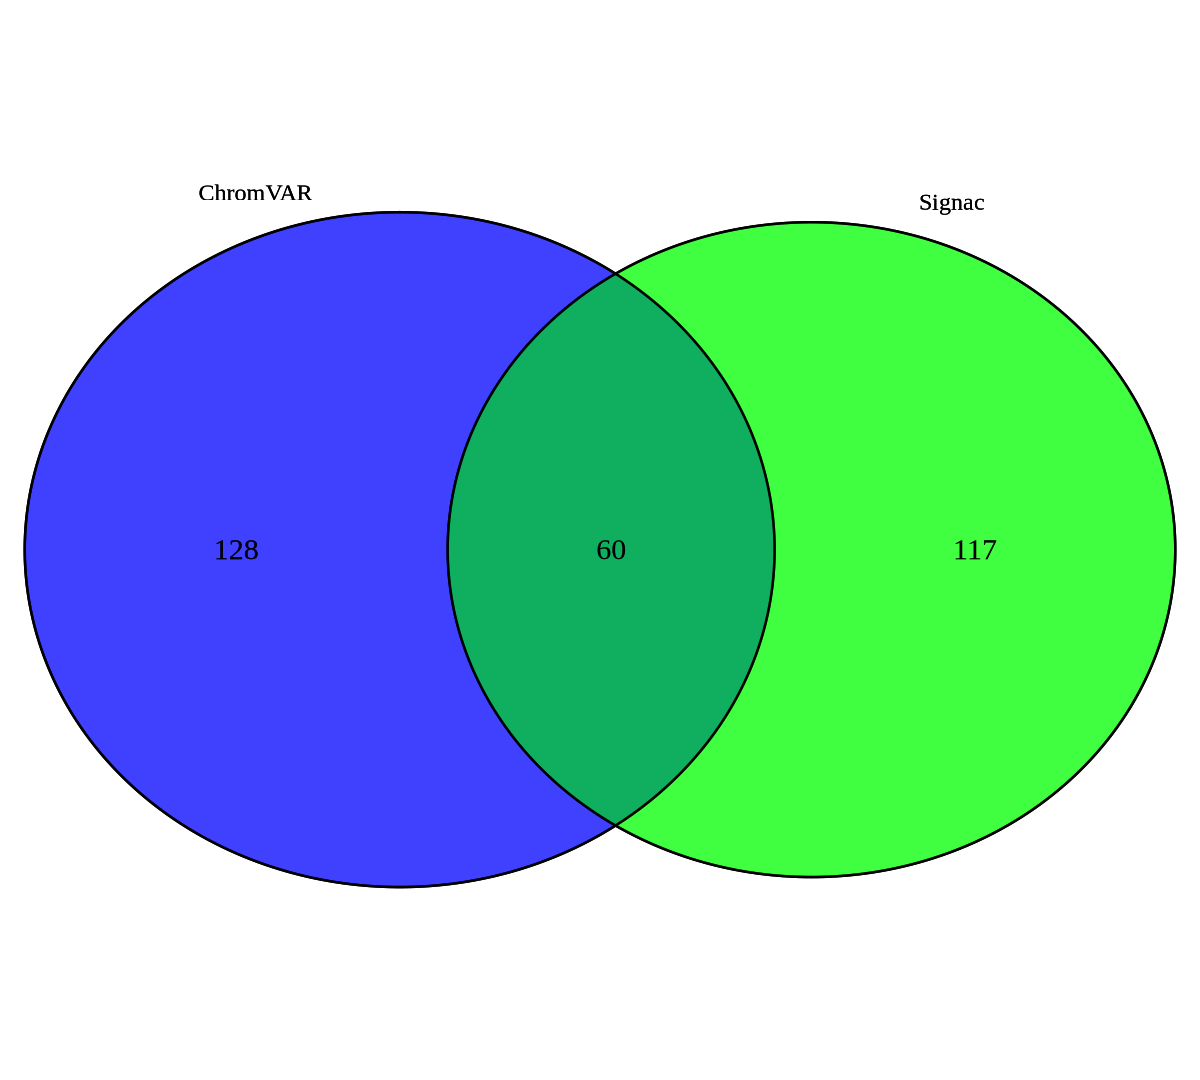

In [57]:


# Set counts
only_diff <- length(only.diff)
only_enrich <- length(only.enrich)
common <- length(common.motifs)

# Plot Venn with counts
options(repr.plot.width = 10, repr.plot.height = 9)
venn.plot <- draw.pairwise.venn(
  area1 = only_diff + common,   # Total in ChromVAR
  area2 = only_enrich + common, # Total in enriched.motifs
  cross.area = common,          # Common motifs
  category = c("ChromVAR", "Signac"),
  fill = c("blue", "green"),
  alpha = 0.5,
  cex = 1.5,
  cat.cex = 1.2,
  cat.pos = c(-20, 20)
)

grid::grid.draw(venn.plot)


## plotting motifs that are common in both

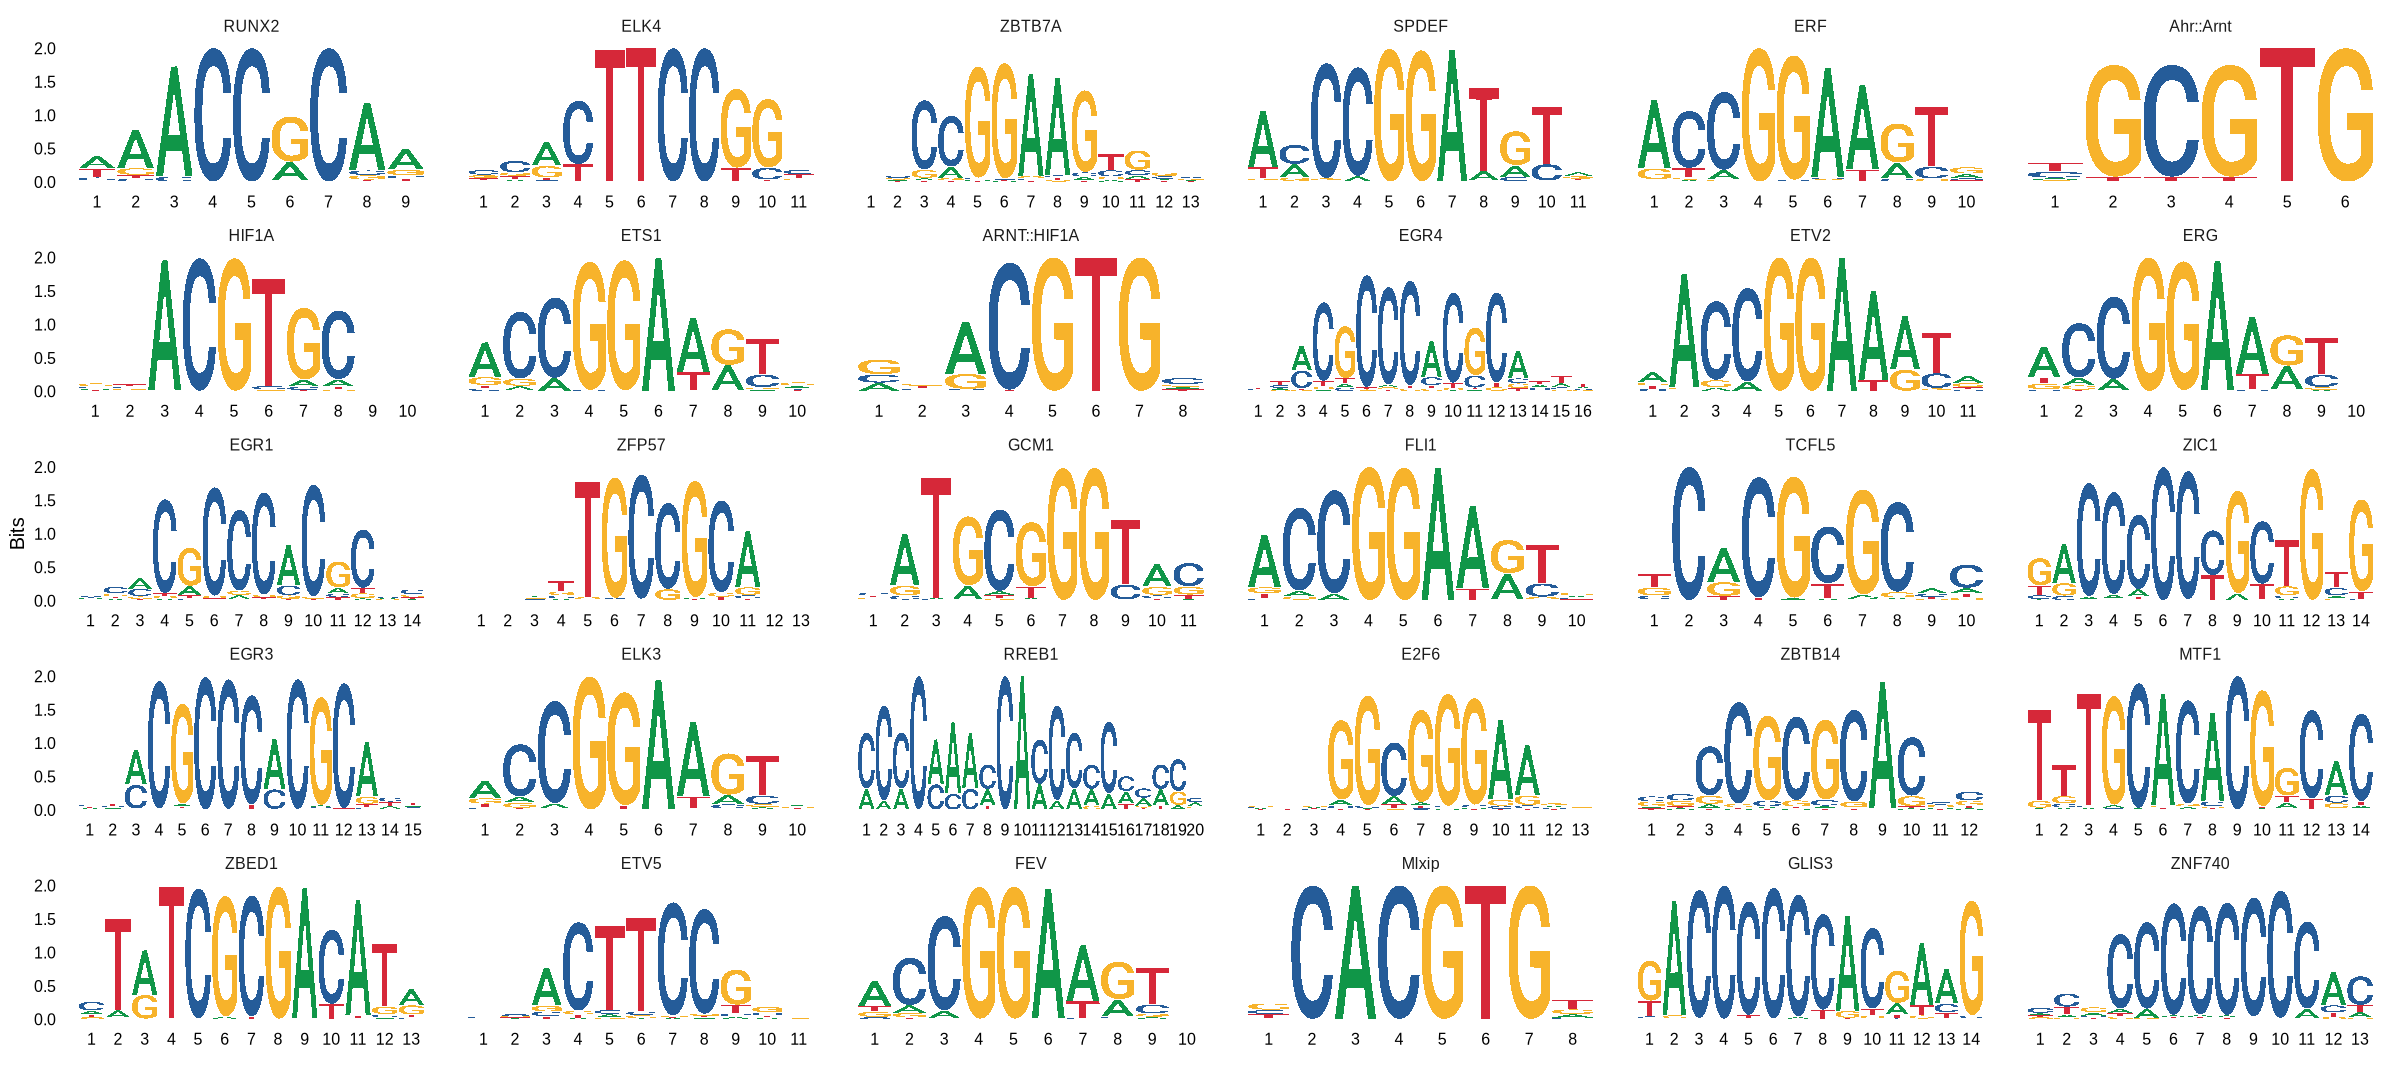

In [58]:
options(repr.plot.width = 20, repr.plot.height = 9)

# Plot first few (you can increase or adjust)
MotifPlot(
  object = PBMC_obj,
  motifs = head(common.motifs,30),
  assay = 'ATAC'
)

## Plotting motifs that are uniquely found by `signac`

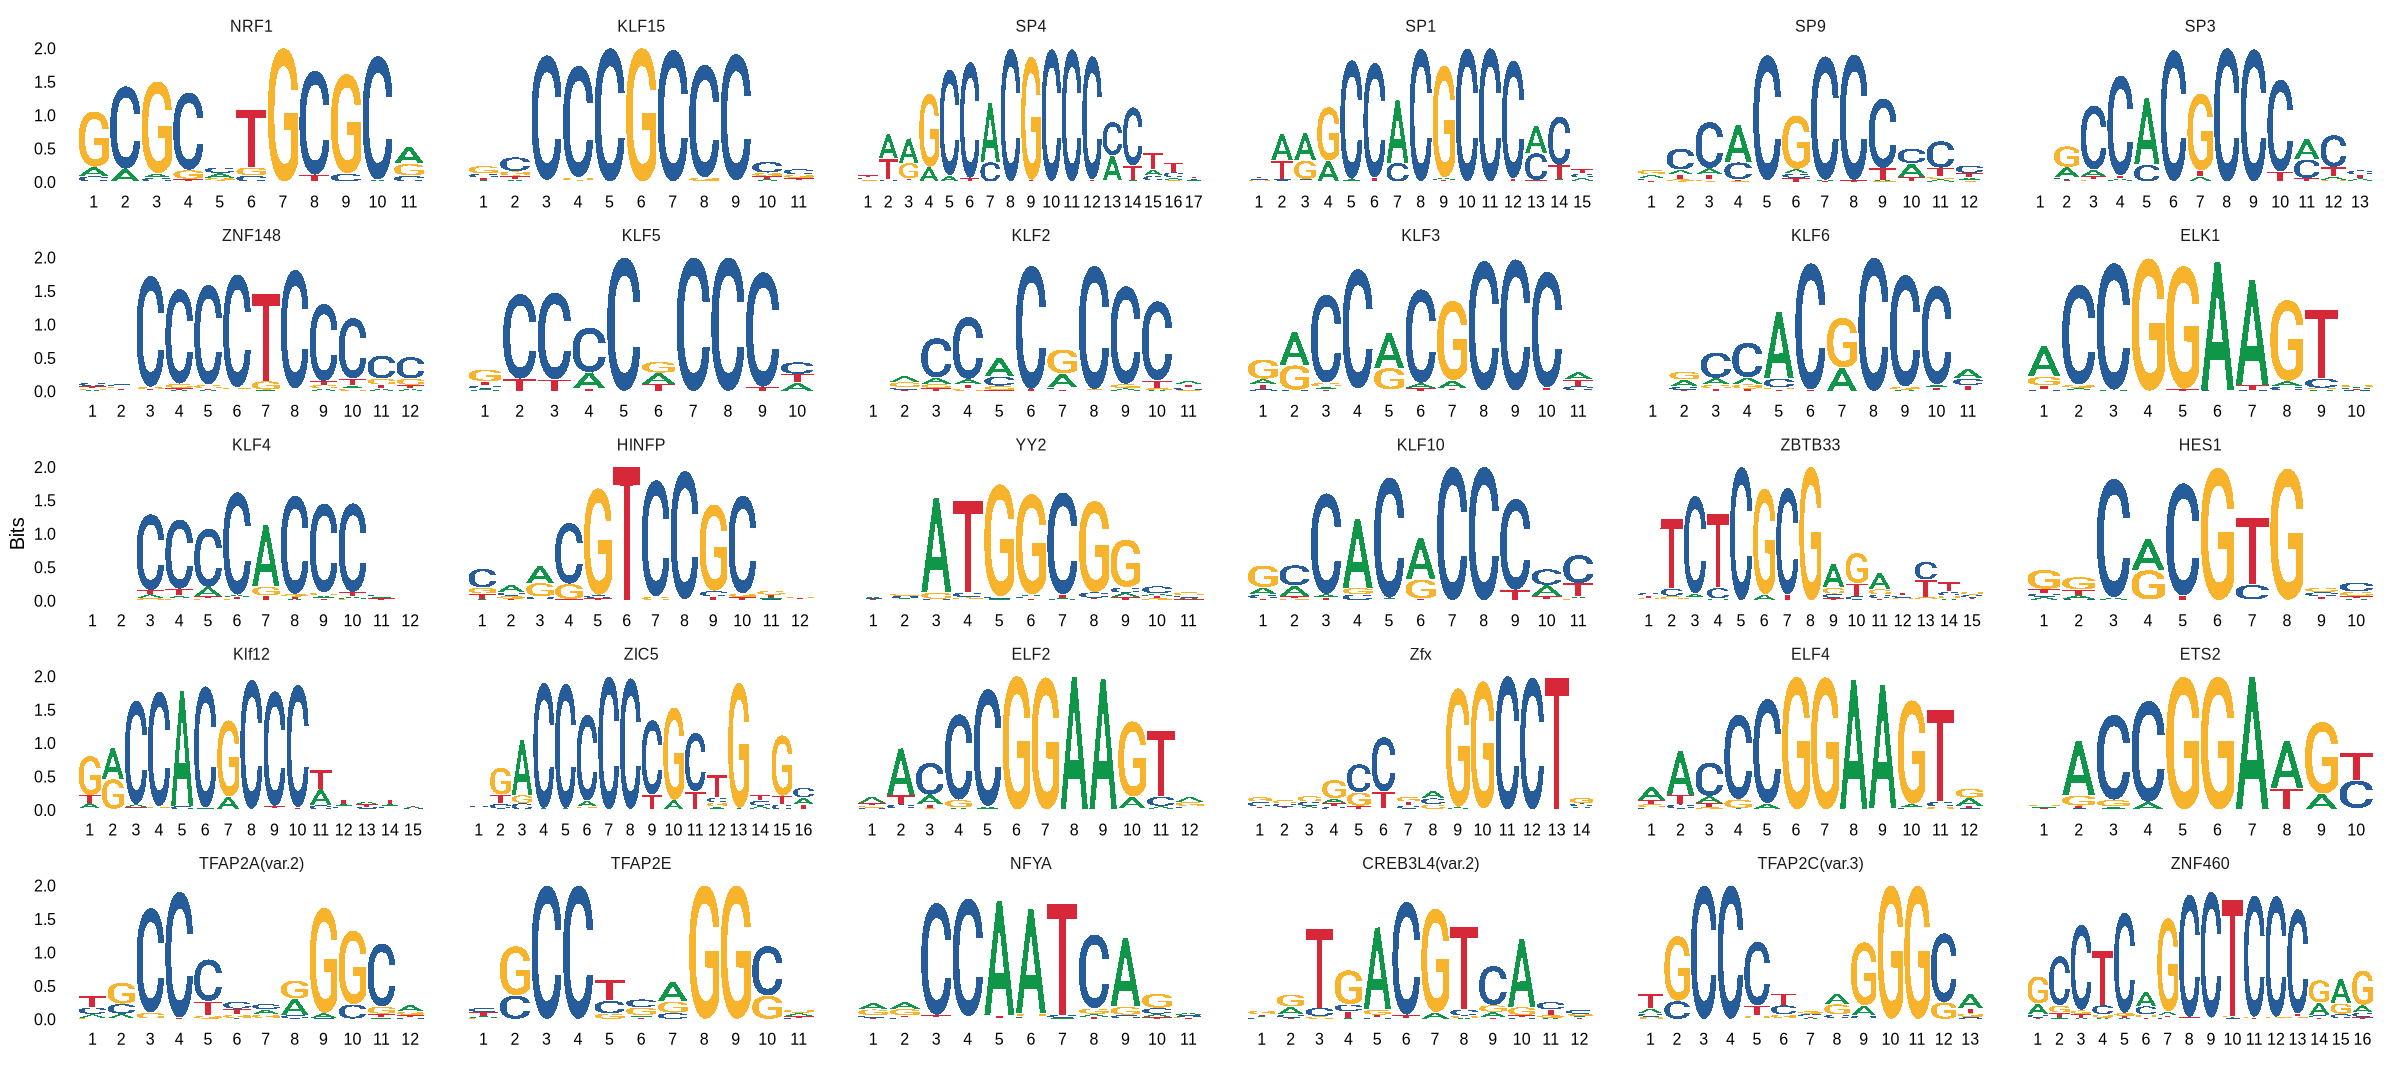

In [59]:
options(repr.plot.width = 20, repr.plot.height = 9)

# Plot first few (you can increase or adjust)
MotifPlot(
  object = PBMC_obj,
  motifs = head(only.enrich,30),
  assay = 'ATAC'
)

## Plotting motifs that are uniquely found by `Chromvar`

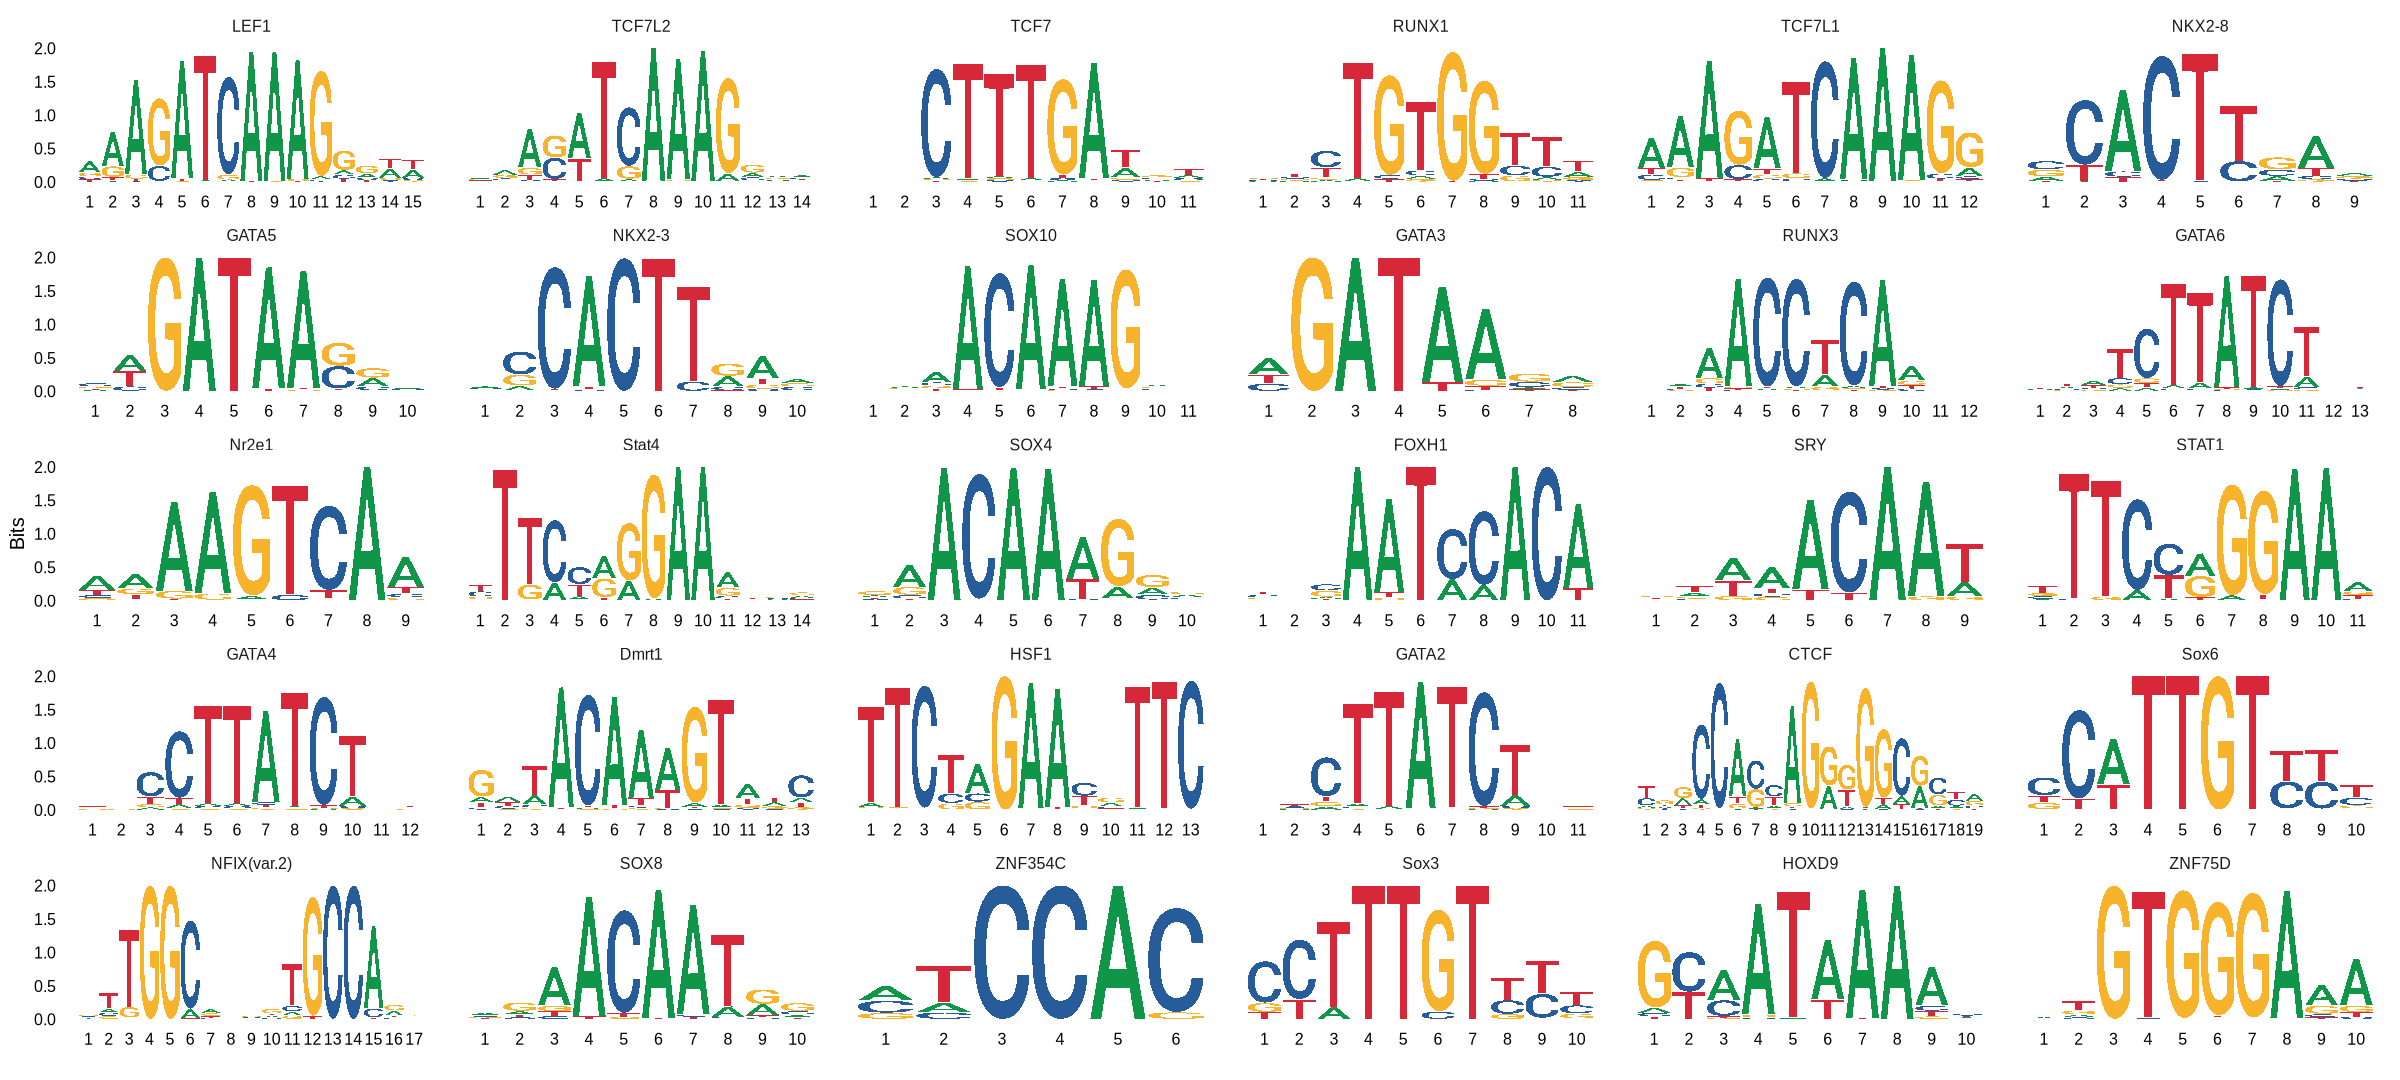

In [60]:
options(repr.plot.width = 20, repr.plot.height = 9)

# Plot first few (you can increase or adjust)
MotifPlot(
  object = PBMC_obj,
  motifs = head(only.diff,30),
  assay = 'ATAC'
)

In [61]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Rocky Linux 8.9 (Green Obsidian)

Matrix products: default
BLAS/LAPACK: /lab-share/Neph-Lee-e2/Public/arather/CondaENVS/envs/workshop/lib/libopenblasp-r0.3.29.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: America/New_York
tzcode source: system (glibc)

attached base packages:
[1] grid      stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] VennDiagram_1.7.3                 futile.logger_1.4.3              
 [3] ggplot2_3.5.2                     ggseqlogo_0.2                    
 [5] patchw